# Plots for 'Network Modelling of Asynchronous Change-Points in Multivariate Time Series'

In [1]:
import csv

import numpy as np
import matplotlib.cm as cm
import networkx as nx
import pandas as pd

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.ndimage import gaussian_filter

## Produce Prior Simulation and Heatmaps from Prior Properties Section

In [2]:
# RNG and helper functions
RNG = np.random.default_rng(seed=2)

# geometric impulse function
def g(t, q):
    return q*(1-q)**(t-1)

def sim_probs(N, q0, q, W0, W, A):
    
    d = len(q0)
    probs = np.zeros((d, N))
    run_lengths = np.ones((d, N))
    
    curr_run_length = np.ones(d)
    prev_run_length = np.ones(d)
    
    for t in range(1, N):
        for j in range(d):
            Z = W0[j] + np.sum(W[:,j])
            pj = (W0[j]*q0[j] + np.sum(W[:, j]*A[:, j]*g(prev_run_length, q[:, j])*(prev_run_length < t))) / Z
            probs[j, t] = pj
            if j == 0:
                if t in [3, 10, 19]:
                    curr_run_length[j] = 1
                else:
                    curr_run_length[j] = prev_run_length[j] + 1
            else:
                if RNG.uniform(0, 1) < pj:
                    curr_run_length[j] = 1
                else:
                    curr_run_length[j] = prev_run_length[j] + 1
        
        prev_run_length = curr_run_length.copy()
        run_lengths[:, t] = curr_run_length
    
    return run_lengths, probs
    

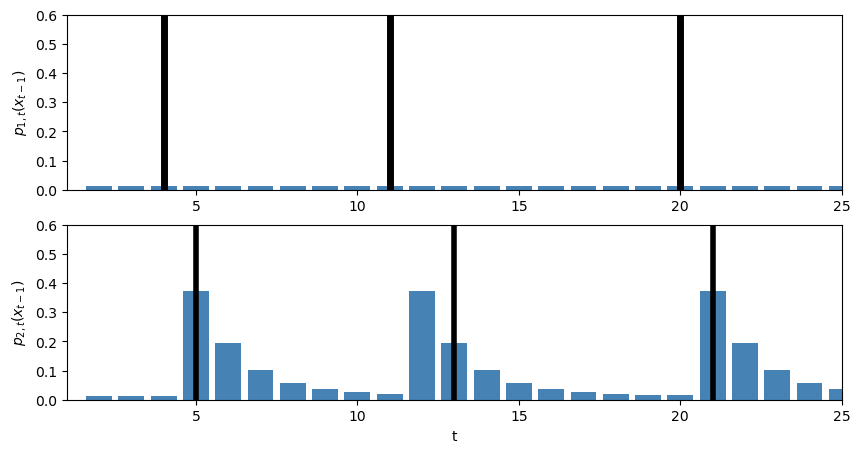

In [3]:
# choose graph: cyclic or acyclic
graph = 'acyclic'
# graph = 'cyclic'

W0 = np.array([1, 1])
q0 = np.array([0.1, 0.1])

A = np.array([[0, 1], 
              [1, 0]])
W = np.array([[1, 5], 
              [5, 1]])
q = np.array([[0.1, 0.5],
              [0.5, 0.1]])

if graph == 'acyclic':
    A[1, 0] = 0
else:
    A[1, 0] = 1

N = 25
run_lengths, probs = sim_probs(N, q0, q, W0, W, A)

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].bar(np.arange(1, N+1), probs[0, :], color='#4682B4')
axs[0].set_ylim(0, 0.6)
axs[0].set_xlim(1, N)
axs[0].set_ylabel('$p_{1, t}(x_{t-1})$',  labelpad=4)
change_indices = np.where(run_lengths[0, 1:] == 1)[0] + 2
for x in change_indices:
    axs[0].axvline(x=x, color='black', linewidth=5)

axs[1].bar(np.arange(1, N+1), probs[1, :], color='#4682B4')
axs[1].set_ylabel('$p_{2, t}(x_{t-1})$',  labelpad=5)
axs[1].set_xlabel('t', rotation=0)
axs[1].set_xlim(1, N)
change_indices = np.where(run_lengths[1, 1:] == 1)[0] + 2
for x in change_indices:
    axs[1].axvline(x=x, color='black', linewidth=4)
axs[1].set_ylim(0, 0.6)
# plt.savefig('sim_dag.pdf', bbox_inches='tight')
# plt.savefig('sim_cycle.pdf', bbox_inches='tight')
plt.show()

C:\Users\k2259011\AppData\Local\Temp\ipykernel_9448\3874891425.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = cm.get_cmap('viridis_r', 20)


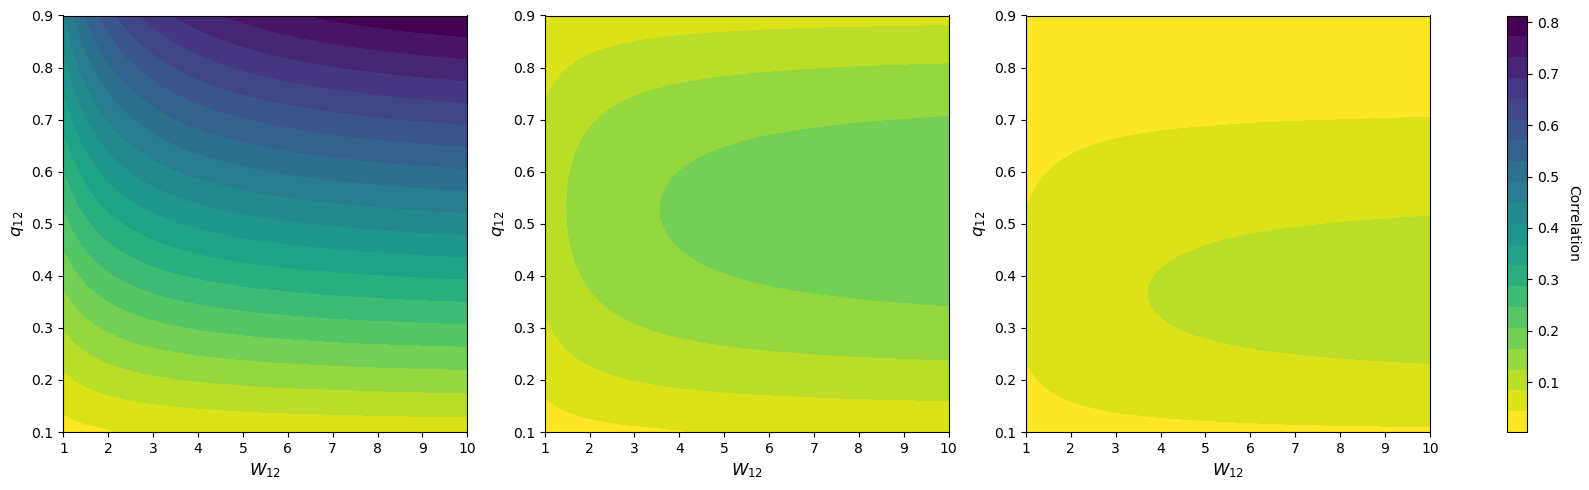

In [4]:
# functions to compute the quantities given in propositions 2 and 3
def lam12t(t, q01, q12):
    base = (1 - q01) * (1 - q12)
    return q12 * q01 * (1 - base**(t - 1)) / (1 - base)

def lam12t_hom(t, q01, q12):
    base = (1 - q01) * (1 - q12)
    if t == 1:
        return q12
    else:
        return q12 * q01 * (1 - base**(t - 1)) / (1 - base) + q12 * base**(t - 1)

def pi12t(t, W02, W12, q02, q01, q12):
    Z = W02 + W12
    return (W02 * q02 + W12 * lam12t(t - 1, q01, q12)) / Z

def pi12t_hom(t, W02, W12, q02, q01, q12):
    Z = W02 + W12
    return (W02 * q02 + W12 * lam12t_hom(t - 1, q01, q12)) / Z

def EUUth(t, h, W02, W12, q01, q02, q12):
    return q01 * pi12t_hom(h + 1, W02, W12, q02, q01, q12)

def CovUUth(t, h, W02, W12, q01, q02, q12):
    Z = W02 + W12
    term1 = lam12t_hom(h, q01, q12)
    term2 = lam12t(t + h - 1, q01, q12)
    return q01 * W12 * (term1 - term2) / Z

def CorUUth(t, h, W02, W12, q01, q02, q12):
    cov = CovUUth(t, h, W02, W12, q01, q02, q12)
    p = pi12t(t + h, W02, W12, q02, q01, q12)
    denom = np.sqrt(q01 * (1 - q01) * p * (1 - p))
    return cov / denom

# Parameters
nbins = 350
w_lower, w_upper = 1, 10
q_lower, q_upper = 0.1, 0.9
q01 = 0.1
q02 = 0.1
W02 = 1

W12s = np.linspace(w_lower, w_upper, nbins)
q12s = np.linspace(q_lower, q_upper, nbins)

vals = [np.zeros((nbins, nbins)) for _ in range(3)]

# Main loop
for i in range(nbins):
    for j in range(nbins):
        W12 = W12s[i]
        q12 = q12s[j]
        for h in range(1, 4):  # h = 1, 2, 3
            vals[h - 1][i, j] = CorUUth(1000, h, W02, W12, q01, q02, q12)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]})

# Color map and z-limits
pal = cm.get_cmap('viridis_r', 20)
zmin = min(np.min(np.abs(vals[2])), np.min(np.abs(vals[0])))
zmax = max(np.max(np.abs(vals[0])), np.max(np.abs(vals[1])))

for h in range(3):
    smoothed = gaussian_filter(np.abs(vals[h]), sigma=2)
    im = axes[h].imshow(
        smoothed.T,
        extent=[W12s[0], W12s[-1], q12s[0], q12s[-1]],
        origin='lower',
        aspect='auto',
        cmap=pal,
        vmin=zmin,
        vmax=zmax
    )
    # axes[h].set_title(f"h = {h + 1}")
    axes[h].set_xlabel(r"$W_{12}$", fontsize=12)
    axes[h].set_ylabel(r"$q_{12}$", fontsize=12)

# Color bar
cbar = plt.colorbar(im, cax=axes[3])
cbar.set_label("Correlation", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()


## Reproduce AUC table, TNR and Log Bayes Factor Tables from Simulation Study Section

In [5]:
def flatten(a:list):
    flat = []
    for i in range(len(a)):
        for j in range(len(a)):
            if i != j:
                flat.append(a[i][j])
    return flat

true_S1 = flatten([[0, 1, 0, 0], 
                   [0, 0, 1, 0], 
                   [0, 0, 0, 1], 
                   [0, 0, 0, 0]])
true_S2 = flatten([[0, 1, 0, 0], 
                   [0, 0, 0, 0], 
                   [0, 0, 0, 1], 
                   [0, 0, 0, 0]])


In [6]:
alpha = 5 / 100 # quantile level
decimals = 3 # decimal places 

for likelihood in ['normal_mean', 'ar_process']:
    for scenario in [1, 2]:
        aucs = []
        for i in range(1, 51, 1):
            path = f"sim_study/results_clean/{likelihood}/adj/NetCP_{scenario}_{i}.csv"
            mat = []
            with open(path, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    mat.append([float(i) for i in row])
            mat = flatten(mat)
            if scenario == 1:
                aucs.append(roc_auc_score(true_S1, mat))
            elif scenario == 2:
                aucs.append(roc_auc_score(true_S2, mat))
        
        print(f"AUC for {likelihood} - S{scenario} = {round(np.mean(aucs), decimals)} ({round(np.quantile(aucs, alpha/2), decimals)}, {round(np.quantile(aucs, 1-alpha/2), decimals)})")

AUC for normal_mean - S1 = 0.986 (0.84, 1.0)
AUC for normal_mean - S2 = 0.993 (1.0, 1.0)
AUC for ar_process - S1 = 0.972 (0.712, 1.0)
AUC for ar_process - S2 = 0.968 (0.711, 1.0)


In [7]:
# for scenario 5 report the average TNR with quantiles when thresholding at 50%
thresh = 0.5
for likelihood in ['normal_mean', 'ar_process']:
    TNRs = []
    
    for i in range(1, 51, 1):
        path = f"sim_study/results_clean/{likelihood}/adj/NetCP_5_{i}.csv"
        mat = []
        with open(path, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                mat.append([float(i) for i in row])
        mat = flatten(mat)
        TNR = sum(1 if pred < thresh else 0 for pred in mat) / len(mat)
        TNRs.append(TNR)
    
    print(f"TNR (threshold = {thresh}) for {likelihood} - S5 = {round(np.mean(TNRs), decimals)} ({round(np.quantile(TNRs, alpha/2), decimals)}, {round(np.quantile(TNRs, 1-alpha/2), decimals)})")

TNR (threshold = 0.5) for normal_mean - S5 = 0.998 (1.0, 1.0)
TNR (threshold = 0.5) for ar_process - S5 = 0.987 (0.917, 1.0)


In [8]:
factors = dict(
		normal_mean = {
			0 : [None]*4,
			1 : [None]*4,
			2 : [None]*4,
			3 : [None]*4,
			4 : [None]*4,
		},
		ar_process = {
			0 : [None]*4,
			1 : [None]*4,
			2 : [None]*4,
			3 : [None]*4,
			4 : [None]*4,
		}
	)

likelihoods = ['normal_mean', 'ar_process']
scenarios = list(range(5))
models = ['NetCP', 'BH', 'GlobalCCP', 'NonGlobalCCP']
inds = list(range(50))
for likelihood in likelihoods:
    for scenario in scenarios:
        model_bfs = defaultdict(list)
        for ind in inds:
            NetCP_path = f'sim_study/results_clean/{likelihood}/NetCP_{scenario}_{ind}.csv'
            with open(NetCP_path, 'r') as file:
                reader=csv.reader(file, delimiter=',')
                NetCP_ev = float(next(iter(reader))[-1])
            
            for model in models:
                path = f'sim_study/results_clean/{likelihood}/{model}_{scenario}_{ind}.csv' 
                with open(path, 'r') as file:
                    reader = csv.reader(file, delimiter=',')
                    model_ev = float(next(iter(reader))[-1])
                model_bfs[model].append(model_ev - NetCP_ev)
        for model, BFs in model_bfs.items():
            l, u = np.quantile(BFs, [0.05, 0.95])
            
            factors[likelihood][scenario][models.index(model)] = (round(sum(BFs)/50, 1), round(l, 1), round(u, 1))

print('Normal Mean Likelihood:')
for model in models:
    print(model +':' + ' '.join([str(factors['normal_mean'][scenario][models.index(model)]) for scenario in [0, 1, 2, 3, 4]]))

print('')
print('AR Process Likelihood:')
for model in models:
    print(model +':' + ' '.join([str(factors['ar_process'][scenario][models.index(model)]) for scenario in [0, 1, 2, 3, 4]]))

Normal Mean Likelihood:
NetCP:(0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0)
BH:(-29.0, -52.9, -6.2) (-17.2, -30.3, -3.5) (-38.5, -52.8, -17.9) (2.6, -2.5, 7.6) (6.2, 4.6, 7.6)
GlobalCCP:(-26.9, -53.0, -2.9) (-15.1, -28.5, 0.8) (-37.1, -53.3, -14.7) (4.2, -2.4, 11.5) (7.5, 4.7, 10.0)
NonGlobalCCP:(-41.8, -85.6, -3.9) (-34.1, -61.4, -8.8) (2.8, -14.1, 21.2) (1.4, -11.9, 15.0) (-15.8, -33.3, -3.9)

AR Process Likelihood:
NetCP:(0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0)
BH:(-17.8, -32.3, -1.4) (-9.1, -22.6, 0.8) (-55.3, -74.2, -39.3) (-21.0, -27.9, -14.7) (7.3, 5.4, 9.5)
GlobalCCP:(-16.2, -32.0, 1.2) (-8.2, -21.1, 1.8) (-54.6, -75.2, -36.8) (-20.1, -27.4, -12.1) (8.1, 5.3, 11.0)
NonGlobalCCP:(-20.8, -45.1, 2.3) (-21.7, -39.3, -5.6) (-19.0, -34.9, -2.8) (-25.2, -41.6, -7.6) (-12.8, -29.7, 1.4)


## Produce plots for Seismology Section

In [9]:
# We ran multiple MCMC chains, choose which one to use
ind = 1

Plot map with graph and adjacency matrix 

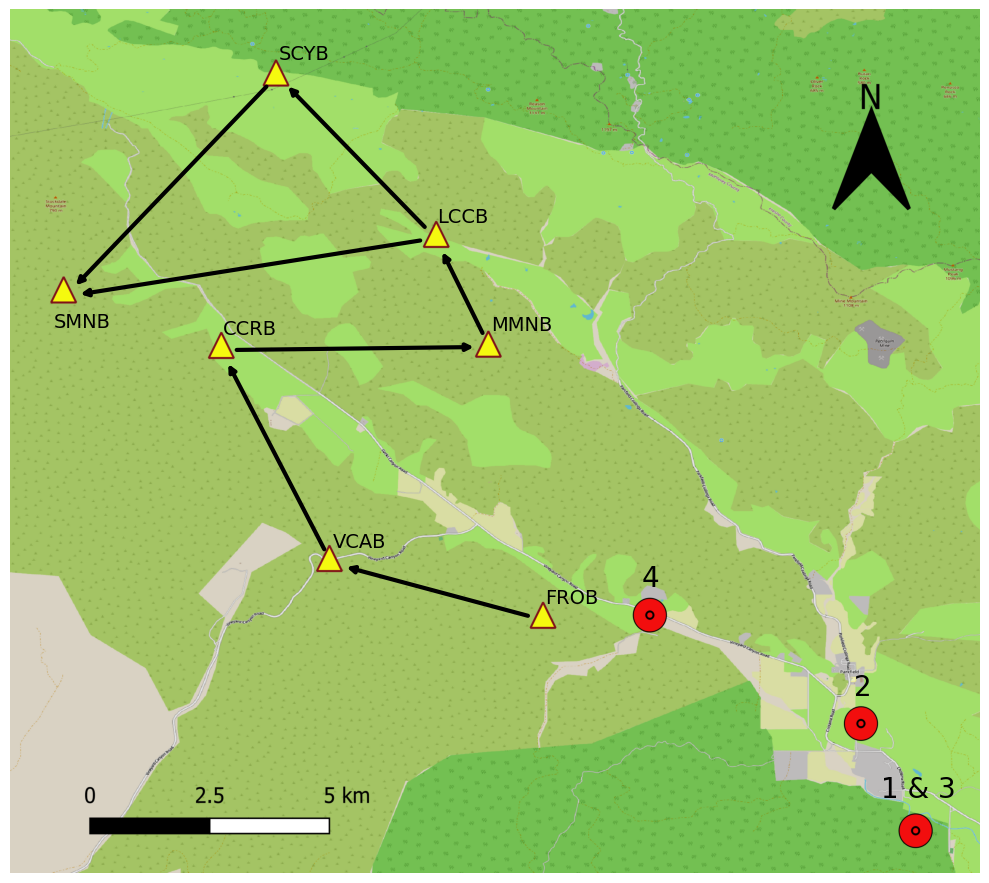

In [10]:
A = np.loadtxt(f"seismic/results/adj_{ind}.csv", delimiter=',')
W = data = np.loadtxt(f"seismic/results/W_{ind}.csv", delimiter=',')

d, _ = A.shape

positions = [(1484, 705), (895, 863), (588, 1456), (153, 1605), (1335, 1465), (1185, 1768), (744, 2221)]
names = ['FROB', 'VCAB', 'CCRB', 'SMNB', 'MMNB', 'LCCB', 'SCYB']

label_pos = positions

quake_labels = ["1 & 3", "2", "4"]
quake_locs = [(2526, 121), (2369, 414), (1778, 718)]

G = nx.DiGraph()
for name, position in zip(names, positions):
    G.add_node(name, pos=position)

edge_alphas = []
for i in range(d):
    for j in range(d):
        if i == j:
            continue
        if A[i, j] > 0.5:
            G.add_edge(names[i], names[j], weight=W[i, j])
            edge_alphas.append(1)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
im = plt.imread("seismic/images/seis_map.png")
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 2701, 0, 2405])
x = np.array(range(300))
plt.axis('off')


pos = {name:loc for name, loc in zip(names, positions)}
nx.draw_networkx_nodes(G,
                        nodelist=names,
                        alpha = 0,
                        pos=pos,
                        node_size=400,
                        # extent=extent,
                        node_color='orange')

nx.draw_networkx_edges(G,
        nodelist=names,
        pos=pos,
        node_size=500,
        alpha = edge_alphas,
        edge_color='black',
        width=3)

edge_labels = {(u, v) : round(G[u][v]['weight'], 2) for u,v in G.edges}

for name, position in zip(names, label_pos):
    x, y = position
    if name != 'SMNB':
        y += 45
        x += 5
    else:
        y -= 85
        x -= 30
    ax.text(x, y, name, size=14)

for i, (label, (x, y)) in enumerate(zip(quake_labels, quake_locs)):
    if i == 0:
        x -= 100
        y += 90
    else:
        x -= 20
        y += 80
    ax.text(x, y, label, size=20)

# fig.savefig("seismic/images/seismic.pdf", bbox_inches='tight', format='pdf')
plt.show()
plt.close()

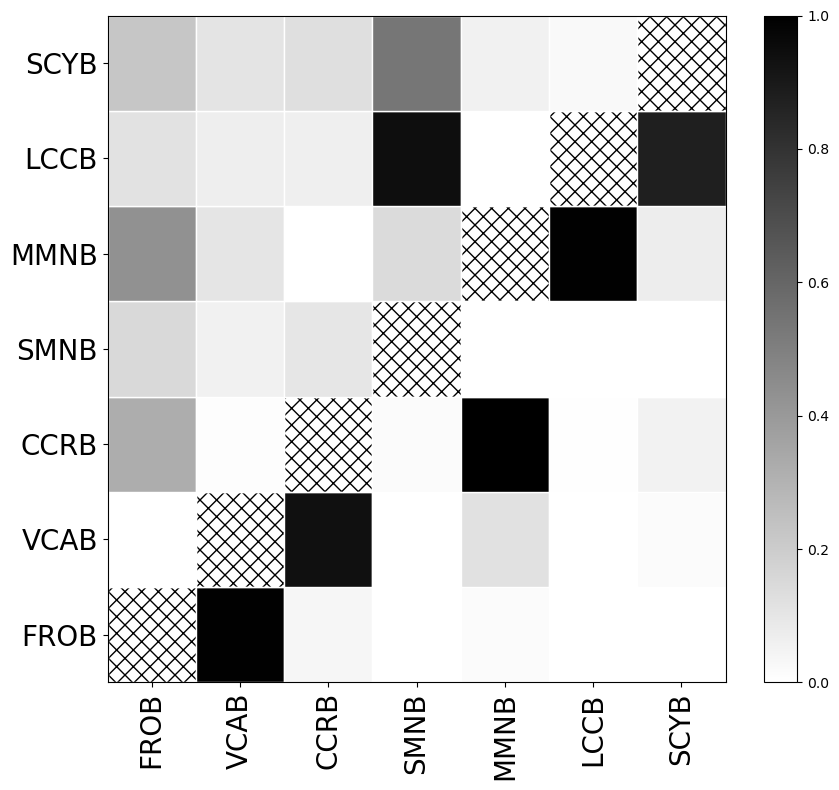

In [11]:
d, _ = data.shape
A = np.ma.masked_array(A, mask=[1 if i == j else 0 for i in range(d) for j in range(d)])
ticks = np.arange(d) + 0.5

plt.rcParams["figure.figsize"] = [9, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
im = ax.pcolormesh(A, cmap=cm.gray_r, edgecolors='white', linewidths=1,
                antialiased=True)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
fig.colorbar(im)
    
# fig.savefig("seismic/images/seismic_adj.pdf", bbox_inches='tight')
ax.patch.set(hatch='xx', edgecolor='black')

plt.show()

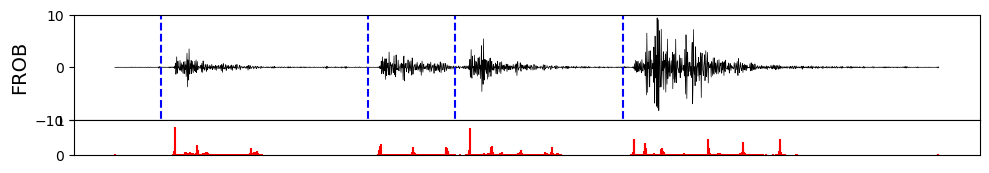

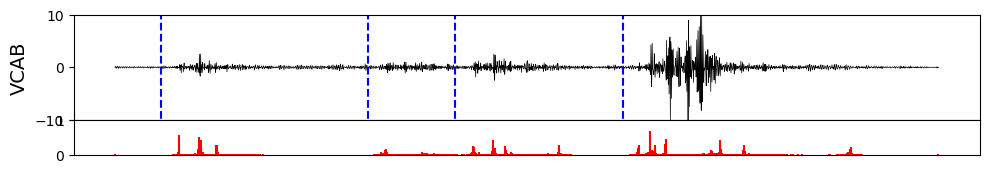

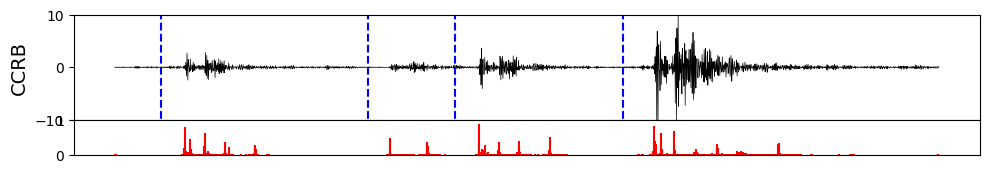

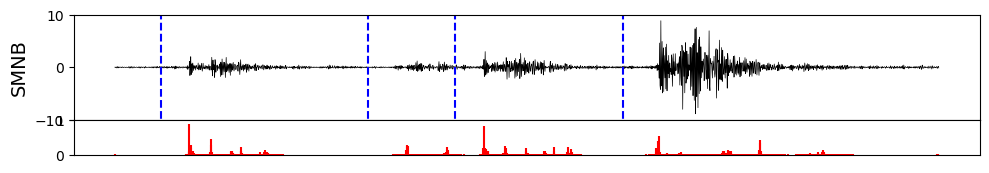

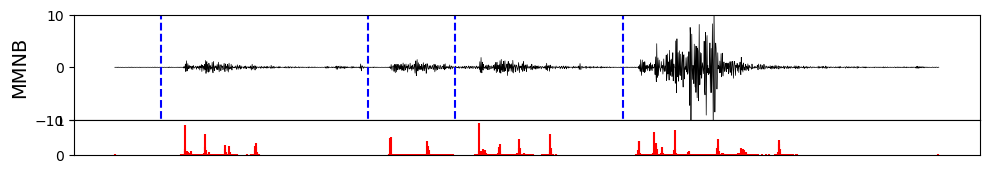

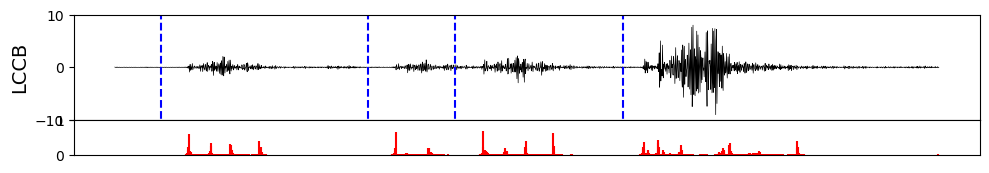

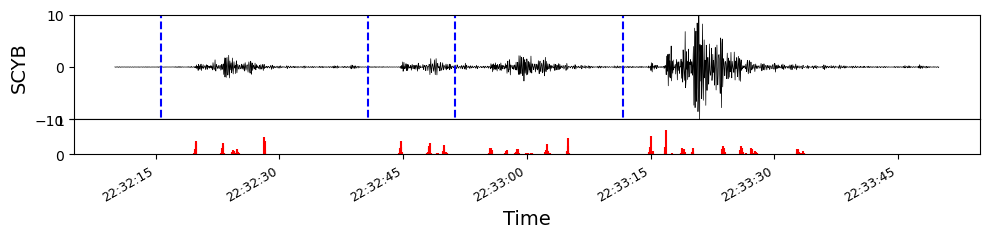

In [12]:
dat = np.loadtxt("seismic/seis_dat.csv", delimiter=',')
U = np.loadtxt(f"seismic/results/out_{ind}.csv", delimiter=',')

d, n = dat.shape

times = np.arange(datetime(2004, 9, 28, 22, 32, 10), datetime(2004, 9, 28, 22, 33, 50), timedelta(seconds=1/20)).astype(datetime)[1:]

earthquakes_inds = [112, 616, 826,  1233]
earthquakes_times = [times[i-1] for i in earthquakes_inds]

fs = 14 # font size

names = ['FROB', 'VCAB', 'CCRB', 'SMNB', 'MMNB', 'LCCB', 'SCYB', 'RMNB'][:d]

inds = [0, 2, 4, 7]
inds = range(d)

for i, name in enumerate(names):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 2), height_ratios=(3,1))
    axs[0].plot(times, dat[i, 1:], linewidth=0.5, color='black')
    axs[0].vlines(earthquakes_times, -100, 100, color='blue', linestyle='dashed')
    axs[0].set_ylabel(name, fontsize=fs, rotation=90)
    axs[0].set_ylim(-10, 10)
    axs[1].stem(times, U[i, :], 'red', markerfmt=" ", basefmt=" ")
    stem = axs[1].stem(times, U[i, :], 'red', markerfmt=" ", basefmt=" ")
    stem[1].set_linewidth(0.05)
    axs[1].set_ylim(0, 1)
    
    if i == (d-1):
        plt.xticks(fontsize=9)
        axs[1].set_xlabel('Time', fontsize=fs)
    else:
        plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    # fig.savefig(f"images/{name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()

## Produce plots for EEG Section

In [13]:
ind = 2 # again choose an MCMC chain to plot

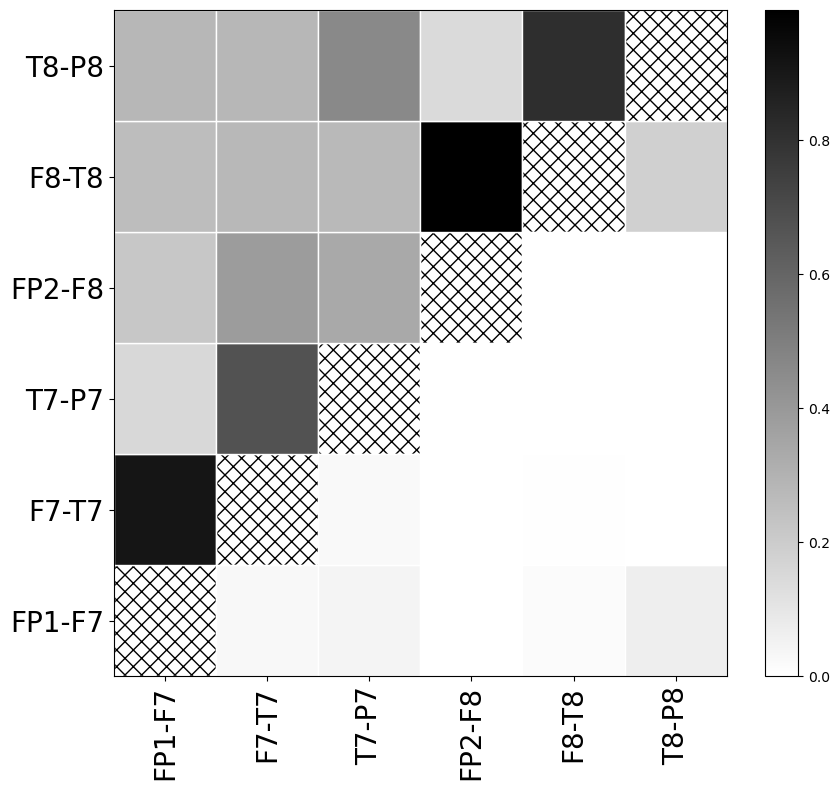

In [14]:
data = np.loadtxt(f"eeg/results/adj_{ind}.csv", delimiter=',')
d, _ = data.shape
data = np.ma.masked_array(data, mask=[1 if i == j else 0 for i in range(d) for j in range(d)])
names = ['FP1-F7', 'F7-T7', 'T7-P7', 'FP2-F8', 'F8-T8', 'T8-P8']
ticks = np.arange(d) + 0.5

plt.rcParams["figure.figsize"] = [9, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
im = ax.pcolormesh(data, cmap=cm.gray_r, edgecolors='white', linewidths=1,
                antialiased=True)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
fig.colorbar(im)
    
# fig.savefig("eeg/images/eeg_adj.pdf", bbox_inches='tight')
ax.patch.set(hatch='xx', edgecolor='black')

plt.show()

(6, 1279)
(6, 1278)


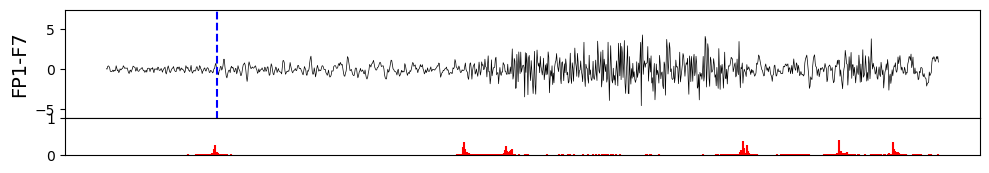

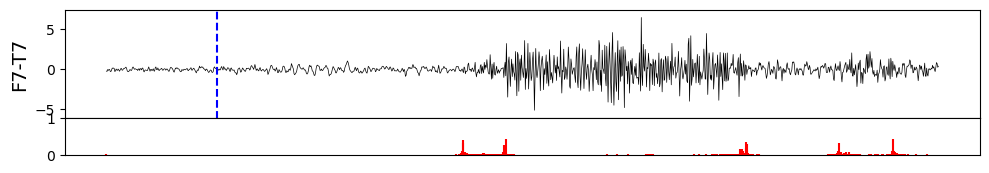

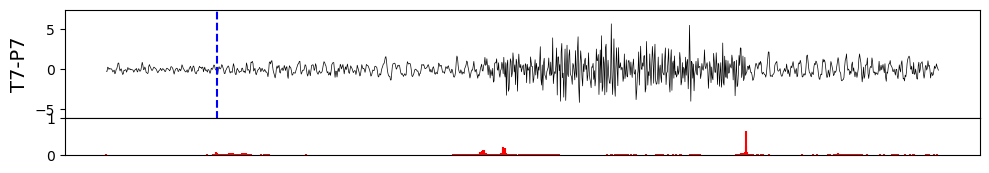

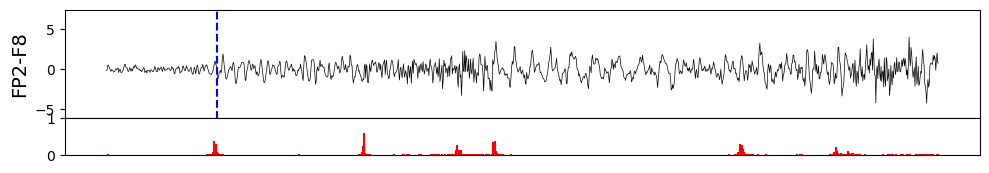

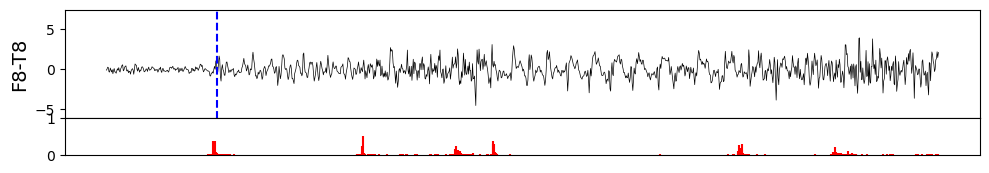

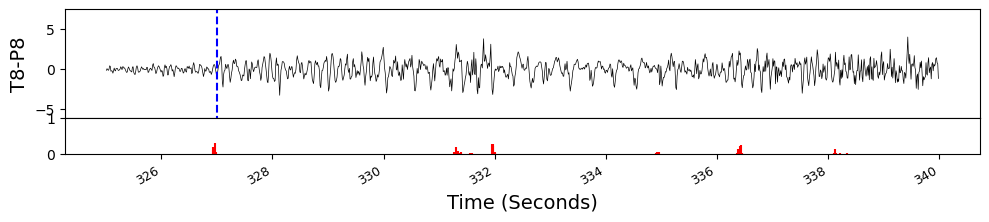

In [15]:
dat = np.loadtxt("eeg/eeg_dat.csv", delimiter=',')
U = np.loadtxt(f"eeg/results/out_{ind}.csv", delimiter=',')

d, n = dat.shape
print(dat.shape)
print(U.shape)

fs = 14

names = ['FP1-F7', 'F7-T7', 'T7-P7', 'FP2-F8', 'F8-T8', 'T8-P8']

times = np.arange(n-1)

start = 325
end = 340

dx = (end-start) / n

times = []
for i in range(n):
    times.append(start + i*dx)

for i, name in enumerate(names):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 2), height_ratios=(3,1))
    axs[0].plot(times[1:], dat[i, 1:], linewidth=0.5, color='black')
    axs[0].vlines([327], -100, 100, color='blue', linestyle='dashed')
    axs[0].set_ylabel(name, fontsize=fs, rotation=90)
    axs[0].set_ylim(np.min(dat)-1, np.max(dat)+1)
    axs[1].stem(times[1:], U[i, :], 'red', markerfmt=" ", basefmt=" ")
    stem = axs[1].stem(times[1:], U[i, :], 'red', markerfmt=" ", basefmt=" ")
    stem[1].set_linewidth(0.05)
    axs[1].set_ylim(0, 1)
    
    if i == (d-1):
        plt.xticks(fontsize=9)
        axs[1].set_xlabel('Time (Seconds)', fontsize=fs)
    else:
        plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    # fig.savefig(f"eeg/images/{name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()